In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("nameses/girl_names.txt", "r").read().splitlines()
words = [word.lower() for word in words]
words[:8]

['abel', 'abelone', 'abigael', 'abigail', 'ada', 'adela', 'adelaide', 'adele']

In [3]:
len(words)

3046

In [4]:
# Building out vocabulary
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: 'ä', 28: 'å', 29: 'æ', 30: 'ç', 31: 'é', 32: 'ø', 0: '.'}
33


In [5]:
# Buliding the dataset with splits
block_size = 3 # context length: how many characters do we take to predict the next one

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])       # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte, Yte = build_dataset(words[n2:])       # 10%

torch.Size([17019, 3]) torch.Size([17019])
torch.Size([2145, 3]) torch.Size([2145])
torch.Size([2065, 3]) torch.Size([2065])


## Main code

In [109]:
n_embd = 10 # the dimensionality of the character embedding  vectors
n_hidden= 200 # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647) # For reproducibility
C = torch.randn((vocab_size, n_embd),               generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden),     generator=g) * (5/3)/((n_embd*block_size)**0.5) #0.2  --> new approach  is Kaiming initialization
# b1 = torch.randn(n_hidden,                          generator=g) * 0.01    useless with batch norm
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print("num parameters:", sum(p.nelement() for p in parameters)) # number of total parameters
for p in parameters:
    p.requires_grad = True

num parameters: 13563


In [110]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # Forward pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the embedding vectors
    # Linear layer
    hpreact = embcat @ W1 # + b1 # hidden layer pre-activation
    # BatchNorm Layer
    #--------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    #-------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 10**-1 if i < 100000 else 100**-1 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    # break

      0/ 200000: 3.5190
  10000/ 200000: 1.9764
  20000/ 200000: 2.3075
  30000/ 200000: 1.4166
  40000/ 200000: 1.6168
  50000/ 200000: 1.8052
  60000/ 200000: 1.8216
  70000/ 200000: 1.4300
  80000/ 200000: 1.2578
  90000/ 200000: 1.6867
 100000/ 200000: 1.6832
 110000/ 200000: 1.7981
 120000/ 200000: 1.5725
 130000/ 200000: 1.5597
 140000/ 200000: 1.4803
 150000/ 200000: 1.3651
 160000/ 200000: 1.4513
 170000/ 200000: 2.0445
 180000/ 200000: 1.4337
 190000/ 200000: 1.3461


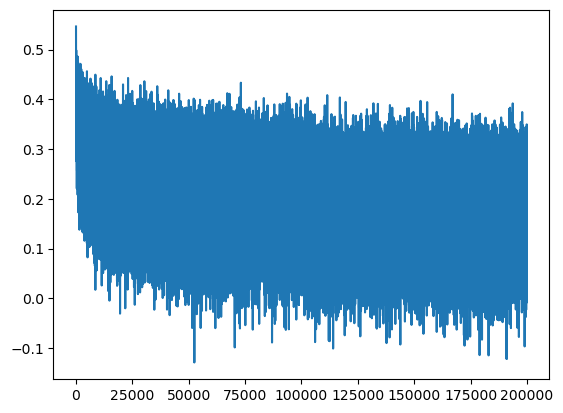

In [111]:
plt.plot(lossi)
plt.show()

In [126]:
# Calibrate the batch-norm at the end of training
with torch.no_grad():
    # Pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)


# No longer necessary after running means and stds

In [ ]:
y = ax + b
y = a1x1 + a2x2 + b

In [127]:
torch.allclose(bnmean, bnmean_running, rtol=1e-01, atol=1e-01)

True

In [128]:
torch.allclose(bnstd, bnstd_running, rtol=1e-01, atol=1e-01)

True

In [131]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size*n_embd)
    hpreact = embcat @ W1 #+ b1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.4522385597229004
val 1.9363845586776733


#### Issue with activation function

In [73]:
(h == 1).unique(return_counts=True)

(tensor([False]), tensor([6400]))

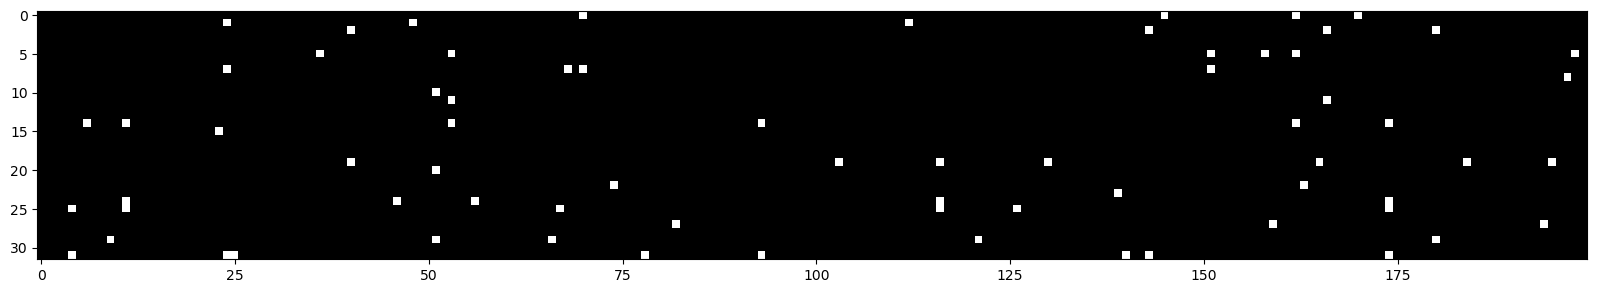

In [74]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")
plt.show();

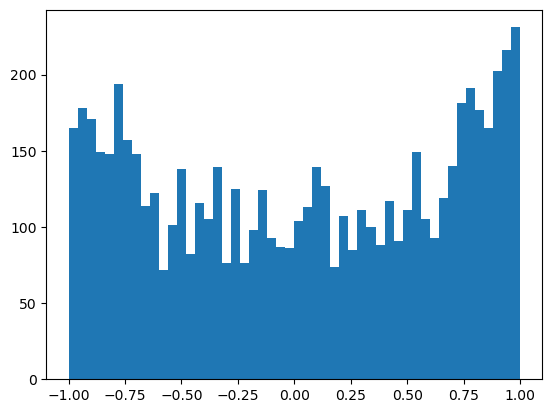

In [75]:
plt.hist(h.view(-1).tolist(), 50)
plt.show()

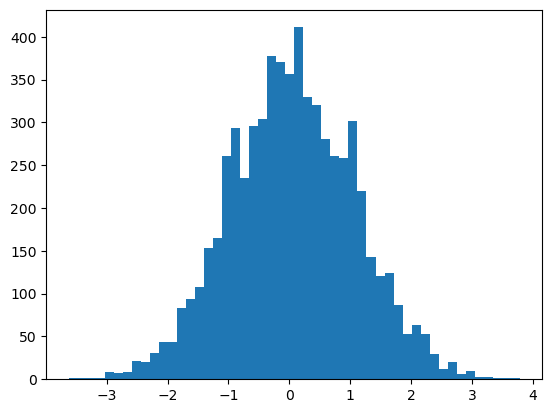

In [76]:
plt.hist(hpreact.view(-1).tolist(), 50)
plt.show()

#### Issue with initialization

In [49]:
# issue with initialization - we expect first loss to be:
-torch.tensor(1/33.).log()

tensor(3.4965)

tensor(0.0006) tensor(1.0051)
tensor(-0.0013) tensor(0.9873)


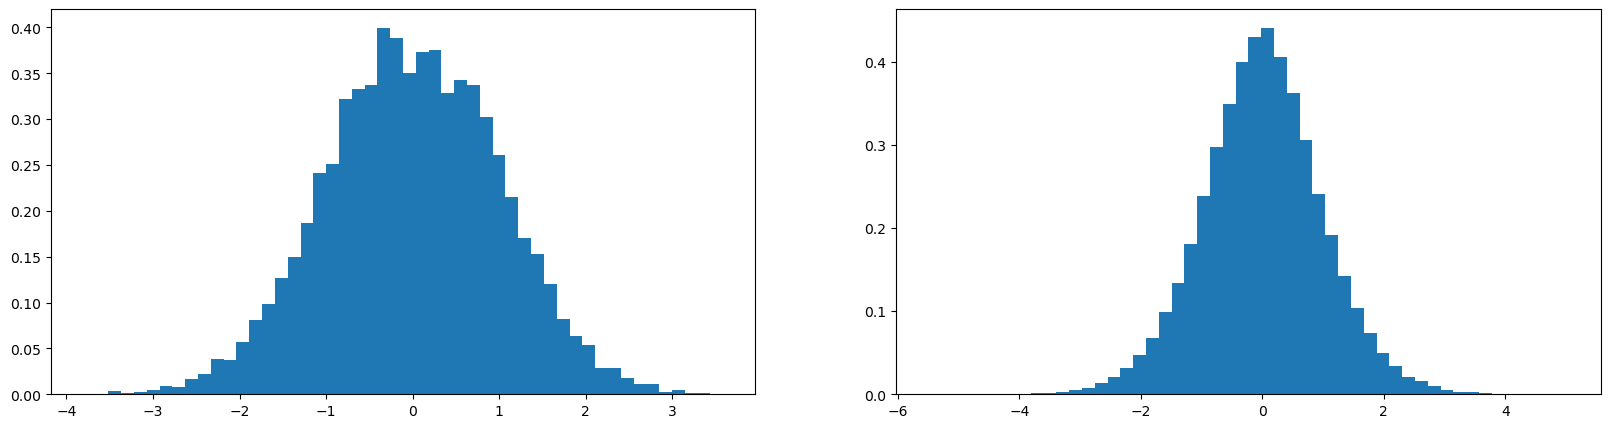

In [86]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
plt.show()

## Drawing sample names 

In [132]:
# Andrejs variant
g = torch.Generator().manual_seed(2147483647)  # Set the random seed for reproducibility

for _ in range(20):
    out = []
    context = [0] * block_size # intialize with all ...
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(1, -1)
        hpreact = embcat @ W1 #+ b1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)  # Hidden layer (flatten embedding and apply W1 and b1)
        logits = h @ W2 + b2  # Logits for the next character
        probs = F.softmax(logits, dim=1)
        
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item() 

        # shift the context window and track the samples
        context = context[1:] + [ix] 
        out.append(ix)
        
        # if samples special character "." -> break
        if ix == 0: 
            break
    print("".join(itos[i] for i in out))

junine.
jana.
adolfrida.
elin.
maire.
toriane.
guri.
signy.
urd.
ilde.
aishbyanne.
irja.
sirpa.
ayla.
thorgfrid.
hilde.
maj.
penny.
wilhelen.
cora.


In [133]:
[name for name in words if "urd" in name]

['urd', 'urda', 'durdei']